##Fetal head segmentation using unet architechture##

loading the dataset files

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d limonhalder/fetal-head-circumference-data
#!kaggle datasets download -d amarchandc/data-foetus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 166M/168M [00:02<00:00, 80.5MB/s]
100% 168M/168M [00:02<00:00, 75.8MB/s]


In [ ]:
!unzip '/content/fetal-head-circumference-data.zip'
#!unzip '/content/data-foetus.zip'

**train and validation dataset**

In [4]:
from sklearn.model_selection import train_test_split
import os

image_main = '/content/Fetal Head Circumference/train_set/Images'
mask_main = '/content/Fetal Head Circumference/train_set/Annotation'

#image_main = '/content/train/images'
#mask_main = '/content/train/Masks'
images = sorted(os.listdir(image_main))
masks = sorted(os.listdir(mask_main))

In [5]:
images[0]

'000_HC.png'

In [6]:
data_dir = os.listdir('/content/Fetal Head Circumference/train_set')
#data_dir = os.listdir('/content/train')

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as TF
import cv2
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries

In [8]:
train_x , val_x , train_y, val_y = train_test_split(images, masks , test_size = 0.2 , random_state = 21)

In [9]:
train_x[0]

'352_HC.png'

/content/Fetal Head Circumference/train_set/Images/000_HC.png


/content/Fetal Head Circumference/train_set/Annotation/000_HC_Annotation.png

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

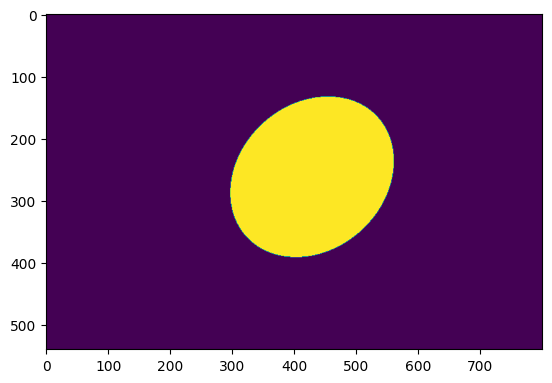

In [12]:
img_path2 = os.path.join(mask_main, train_y[1])
c= Image.open(img_path2)
#v = Image.fromarray(c)
plt.imshow(ndi.binary_fill_holes(Image.open(img_path2))) 

In [ ]:
#!git clone https://github.com/pytorch/vision.git
#!cd vision
#!git checkout v0.3.0

**preparing the data transforms and converting data in tensor**

In [13]:
#dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
  def __init__(self, data_dir, image_main, train_x, mask_main, train_y, transforms = None):
    self.data_dir = data_dir
    self.image_main = image_main
    self.train_x = train_x
    self.mask_main = mask_main
    self.train_y = train_y
    self.transforms = transforms
    #self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.train_x)

  def __getitem__(self, index):
    
    #img_path = os.path.join(self.image_dir, self.image_dir[index])
    img_path = os.path.join(self.image_main, self.train_x[index])
    #mask_path = os.path.join(self.mask_dir, self.mask_dir[index])#.replace('.png', '_Annotation.png'))
    mask_path = os.path.join(self.mask_main, self.train_y[index])
    image = (Image.open(img_path).convert('RGB'))
    mask = (Image.open(mask_path).convert('L')) #dtype = np.float32)
    mask = ndi.binary_fill_holes(mask) 
    mask = (Image.open(mask_path).convert('L'))
    #image= np.array(image)
    #mask=mask.astype("uint8")
    mask[mask == 255.0] = 1.0 #we will use sigmoid at the end..so this indicates correct pixels ...white
    #plt.imshow(image)
    #augmentation
    #if self.transform is not None:
    #  augmented = self.transform(image=image, mask=mask)
    #  image = augmented['image']
    #  mask = augmented['mask']
    #image = torch.from_numpy(image).float()
    #mask = torch.from_numpy(mask).float()
    if self.transforms is not None:
      image = self.transforms(image)
      mask = self.transforms(mask)
      #img, target = self.transforms(img, target)
    #image = torch.from_numpy(image).float()
    #mask = torch.from_numpy(mask).float()
    #np_img = np.squeeze(np_img, axis=2)  # axis=2 is channel dimension 
    #pil_img = Image.fromarray(np_img)
    #image = np.array(image)
    #mask = np.array(mask)
    #Image.fromarray((x * 255).astype(np.uint8))
    #image = np.squeeze(image, axis=0)
    #mask = np.squeeze(mask, axis=0)
    #image = Image.fromarray(image*1).astype(np.uint8).resize(512,512).convert('RGB')
    #mask = Image.fromarray(mask*1).astype(np.uint8).resize(512,512).convert('L')
    #image= to_tensor(image)            
    #mask=255*to_tensor(mask) 
    #image, mask = image.detach().cpu().numpy(), mask.detach().cpu().numpy()
    return image, mask

In [14]:
#dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
  def __init__(self, data_dir, image_main, train_x, mask_main, train_y, transforms = None):
    self.data_dir = data_dir
    self.image_main = image_main
    self.train_x = train_x
    self.mask_main = mask_main
    self.train_y = train_y
    self.transforms = transforms
  
  def __len__(self):
    return len(self.train_x)

  def __getitem__(self, index):
    
    #img_path = os.path.join(self.image_dir, self.image_dir[index])
    img_path = os.path.join(self.image_main, self.train_x[index])
    #mask_path = os.path.join(self.mask_dir, self.mask_dir[index])#.replace('.png', '_Annotation.png'))
    mask_path = os.path.join(self.mask_main, self.train_y[index])
    image = (Image.open(img_path).convert('RGB'))
    mask = (Image.open(mask_path).convert('L')) #dtype = np.float32)
    mask = ndi.binary_fill_holes(mask) 
    mask = (Image.open(mask_path).convert('RGB'))
    #image= np.array(image)

    if self.transforms is not None:
      image = self.transforms(image)
      mask = self.transforms(mask)
  
    return image, mask

In [15]:
#transforms
train_transform = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2, 0.2, 0.2], std=[0.2, 0.2, 0.2])]) 
val_transform = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2, 0.2, 0.2], std=[0.2, 0.2, 0.2])]) 

In [16]:
train_dataset = CarvanaDataset(data_dir, image_main, train_x, mask_main, train_y, transforms = train_transform)
val_dataset = CarvanaDataset(data_dir, image_main, val_x, mask_main, val_y, transforms = val_transform)

In [17]:
#dataloader
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True)

In [18]:
train_loader

##unet architechture##

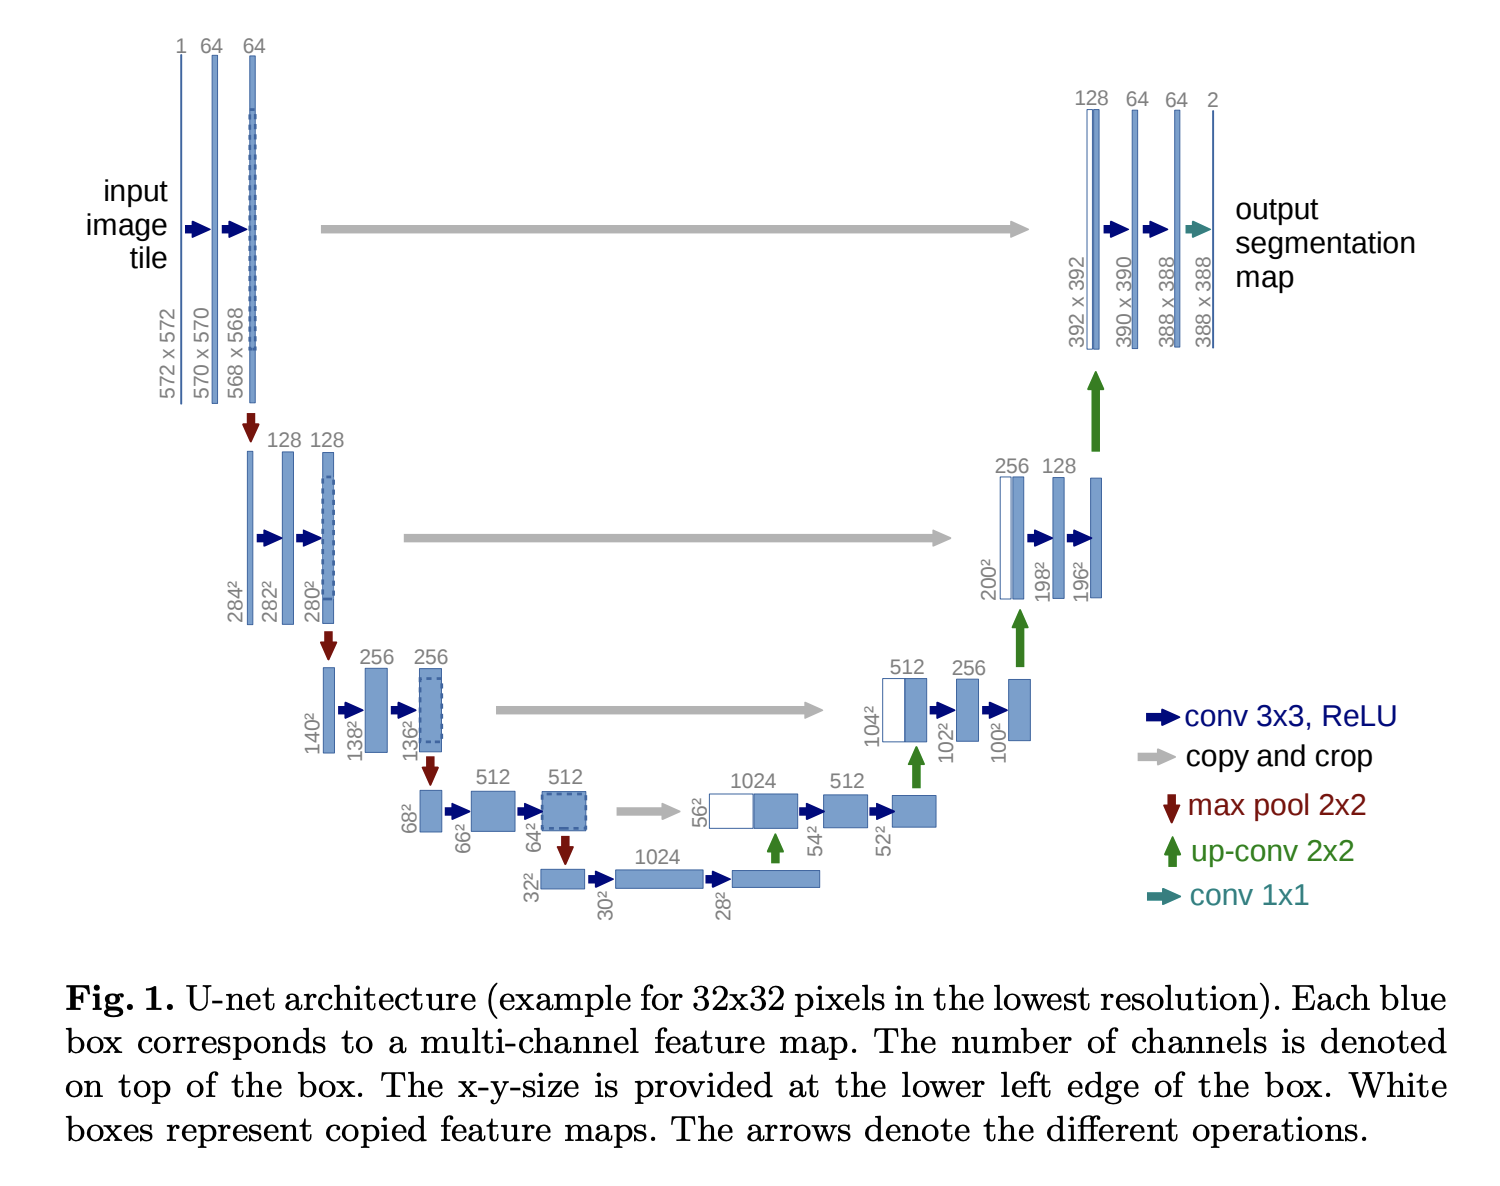

**preparing the code for unet**

In [19]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias= False),
        nn.BatchNorm2d(out_channels),  #here in original paper this is not used..instead bias is set to true but it is same ..if we apply both ..bias will get cancelled out
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias= False),
        nn.BatchNorm2d(out_channels),  #here in original paper this is not used..instead bias is set to true but it is same ..if we apply both ..bias will get cancelled out
        nn.ReLU(inplace= True),
    )

  def forward(self, x):
    return self.conv(x)

In [20]:
class UNET(nn.Module):
  def __init__(
      self, in_channels= 3, out_channels= 1, features= [64,128,256,512], 
  ):
    super(UNET, self).__init__()
    self.downs= nn.ModuleList()
    self.ups= nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride= 2)

    #down part
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels= feature

    #for up part
    for feature in reversed(features):
      #skip connect
      self.ups.append(
          nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
      )
      #up conv 
      self.ups.append(DoubleConv(feature*2, feature))
    
    #bottom layer flat
    self.bottleneck= DoubleConv(features[-1], features[-1]*2)
    self.final_conv= nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x= down(x)
      skip_connections.append(x)
      x= self.pool(x)

    x= self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x= self.ups[idx](x)
      skip_connection= skip_connections[idx//2]

      #if input is not divisible by 16...it would not concatenate due to size diff
      if x.shape != skip_connection.shape:
        x= TF.resize(x, size= skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x= self.ups[idx+1](concat_skip)

    return self.final_conv(x)

def test():
  x = torch.randn((3, 1, 160, 160))
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

if __name__ == '__main__':
  test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [21]:
def dice_loss(pred, target, smooth = 1e-5):

    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) 
    
    dice= 2.0 * (intersection + smooth) / (union+ smooth)    
    loss = 1.0 - dice
    
    return loss.sum(), dice.sum()

In [22]:
model = UNET(in_channels=3, out_channels=1)   #if no. of output classes more...change to cross entropy
#criterion = nn.BCEWithLogitsLoss()
criterion = dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

**training using dice loss**

In [ ]:
num_epoch = 10
train_loss=[]
val_loss=[]
for epoch in range(num_epoch):
  running_loss= 0.0
  model.train()

  for i, (images, masks) in enumerate(train_loader):
    
    optimizer.zero_grad()
    outputs= model(images)
    loss, dice_coeff = criterion(outputs, masks)
    #loss = criterion(outputs, masks)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    #if (i) % 10 ==0:
    #print(f'epoch [{i}/{num_epoch}], loss: {loss.item()/50:.4f}, dice coeff:{dice_coeff.item()/50:.4f}')  #len/batch_size

  with torch.no_grad():
    val_loss = 0.0
    dice_coeff_val=0.0
    model.eval()
    for images_val, masks_val in val_loader:
        output_val = model(images_val)
        val_loss2,dice_coeff_val = criterion(output_val, masks_val)
        val_loss+=val_loss2
    print(dice_coeff_val)
  epoch_loss = running_loss/len(train_loader)
  #train_loss.append(epoch_loss.numpy())
  val_epoch_loss = val_loss/len(val_loader)
  #val_loss.append(val_epoch_loss.numpy())
  print(f"Epoch [{epoch+1}/{num_epoch}], train dice loss: {epoch_loss/50:.4f}, validation dice loss: {val_epoch_loss/50:.4f}")

tensor(-8.8369)
Epoch [1/10], train dice loss: 2.3022, validation dice loss: 2.0655
tensor(-46.1442)
Epoch [2/10], train dice loss: 2.7415, validation dice loss: 2.7002
tensor(-46.3440)
Epoch [3/10], train dice loss: 2.8091, validation dice loss: 2.7035
tensor(-44.9969)
Epoch [4/10], train dice loss: 2.7938, validation dice loss: 2.6677
tensor(-16.3533)
Epoch [5/10], train dice loss: 2.6239, validation dice loss: 3.6231
tensor(-45.9055)
Epoch [6/10], train dice loss: 2.7169, validation dice loss: 2.6918
tensor(-46.2127)
Epoch [7/10], train dice loss: 2.8059, validation dice loss: 2.6994
tensor(-45.7852)
Epoch [8/10], train dice loss: 2.7994, validation dice loss: 2.6884
tensor(-45.5671)
Epoch [9/10], train dice loss: 2.7843, validation dice loss: 2.6734
tensor(-45.2592)
Epoch [10/10], train dice loss: 2.7650, validation dice loss: 2.6628


**training using bce loss**

In [ ]:
num_epoch = 10
for epoch in range(num_epoch):
      running_loss= 0.0
      model.train()

      for i, (images, masks) in enumerate(train_loader):
    
        optimizer.zero_grad()
        outputs= model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    #if (i+1) % 2 ==0:
    #print(f'epoch [{epoch+1}/{num_epoch}], loss: {loss.item():.4f}')

      with torch.no_grad():
        val_loss = 0.0
        model.eval()
        for images_val, masks_val in val_loader:
            output_val = model(images_val)
            val_loss += criterion(output_val, masks_val).item()

      epoch_loss = running_loss/len(train_loader)
      val_epoch_loss = val_loss/len(val_loader)
      print(f"Epoch [{epoch+1}/{num_epoch}], train loss: {epoch_loss:.4f}, validation loss: {val_epoch_loss:.4f}")

Epoch [1/10], train loss: 0.0603, validation loss: 0.0429
Epoch [2/10], train loss: 0.0346, validation loss: 0.0369
Epoch [3/10], train loss: 0.0332, validation loss: 0.0323
Epoch [4/10], train loss: 0.0313, validation loss: 0.0326
Epoch [5/10], train loss: 0.0296, validation loss: 0.0283
Epoch [6/10], train loss: 0.0285, validation loss: 0.0274
Epoch [7/10], train loss: 0.0279, validation loss: 0.0273
Epoch [8/10], train loss: 0.0269, validation loss: 0.0300
Epoch [9/10], train loss: 0.0266, validation loss: 0.0260
Epoch [10/10], train loss: 0.0265, validation loss: 0.0262


In [ ]:
train_loss = [0.0603, 0.0346, 0.0332, 0.0313, 0.0296, 0.0285, 0.0279, 0.0269, 0.0266, 0.0265]
val_loss = [0.0429, 0.0369, 0.0323, 0.0326, 0.0283, 0.0274, 0.0273, 0.0300, 0.0260, 0.0262]

**train loss curve**

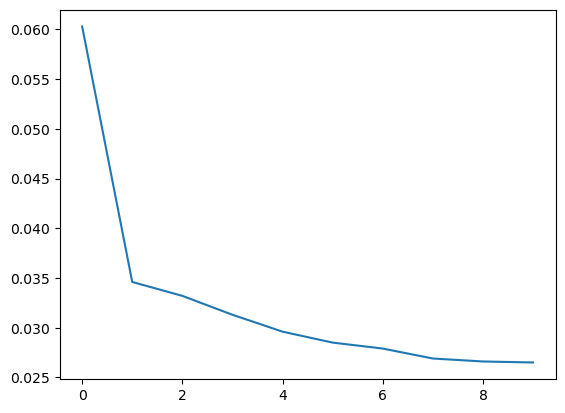

In [ ]:
plt.plot(range(10), train_loss)

**validation loss curve**

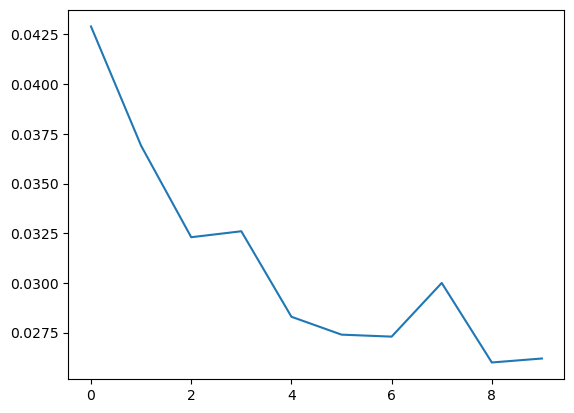

In [ ]:
plt.plot(range(10), val_loss)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

**loading the saved model**

In [ ]:
#model_save_name = 'classifier.pt'
path = F'/content/model.pth'

#path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
images_test = sorted(os.listdir('/content/Fetal Head Circumference/test_set'))

In [ ]:
test_main = '/content/Fetal Head Circumference/test_set'

In [ ]:
images_test[0]

'000_HC.png'

In [ ]:
model

**test dataset analysis**

In [ ]:
test_transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2, 0.2, 0.2], std=[0.2, 0.2, 0.2])
])

In [ ]:
#dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch

class testDataset(Dataset):
  def __init__(self, data_dir, image_main, train_x, transforms = test_transform):
    self.data_dir = data_dir
    self.image_main = image_main
    self.train_x = train_x
    #self.mask_main = mask_main
    #self.train_y = train_y
    self.transforms = transforms
  
  def __len__(self):
    return len(self.train_x)

  def __getitem__(self, index):
    
    #img_path = os.path.join(self.image_dir, self.image_dir[index])
    img_path = os.path.join(self.image_main, self.train_x[index])
    #mask_path = os.path.join(self.mask_dir, self.mask_dir[index])#.replace('.png', '_Annotation.png'))
    #mask_path = os.path.join(self.mask_main, self.train_y[index])
    image = (Image.open(img_path).convert('RGB'))
    #mask = (Image.open(mask_path).convert('L')) #dtype = np.float32)
    #mask = ndi.binary_fill_holes(mask) 
    #mask = (Image.open(mask_path).convert('L'))
    #image= np.array(image)
    

    if self.transforms is not None:
      image = self.transforms(image)
      #mask = self.transforms(mask)
    #image = Image.fromarray(image).astype(np.uint8).resize(160,160).convert('RGB')
    #image= np.array(image)
    #image = torch.from_numpy(image).float()
    return image

In [ ]:
test_dataset = testDataset(data_dir, test_main, images_test, transforms = test_transform)

In [ ]:
test_dataset

In [ ]:
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#model.to(device)
#tensor.to(device)

**predicting the test data**

In [ ]:
model.eval()
predictions = []
with torch.no_grad():
  for inputs in test_loader:
    #inputs = inputs.to(device)
    outputst = model(inputs)
    outputs = torch.sigmoid(outputst)
    #predictions = (predictions>0.5).astype(np.uint8) 
    #
    #if len(predictions)>0:
    #  predictions1= np.argmax(predictions, axis=0)
    #else:
    #  predictions=[]
    predictions.append((outputs.cpu().numpy()>0.009).astype(np.uint8) )
    #predictions.append(outputs.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
#predictions = (predictions>0.008).astype(np.uint8) 

In [ ]:
predictions1= np.transpose(predictions, (0, 2, 3, 1))
#predictions1= np.transpose(predictions, (1, 0))

In [ ]:
#predictions1= predictions[3].squeeze(axis=1)
#predictions1= predictions[3].squeeze(axis=0)

In [24]:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch

def show_img_mask(img, mask):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)
        
    img_mask=mark_boundaries(np.array(img), 
                        np.array(mask),
                        mode= 'subpixel',
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)
    

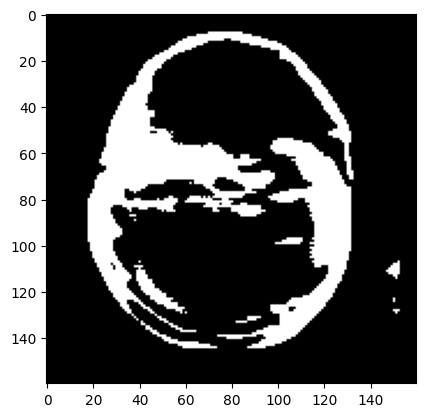

In [ ]:
mask = ndi.binary_fill_holes(predictions1[124]) 
plt.imshow(mask, cmap= 'gray')
plt.show()
#show_img_mask(test_dataset[3], mask)

In [ ]:
#h=[0,124]

original mask on image

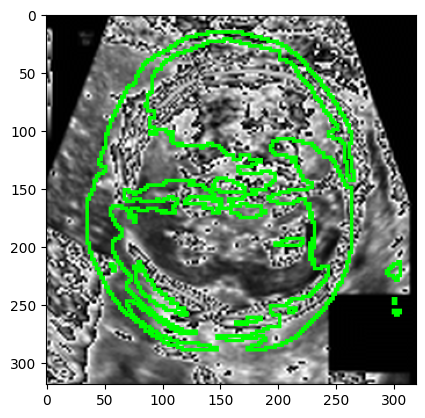

In [ ]:
show_img_mask(test_dataset[124], predictions1[124])

processed mask

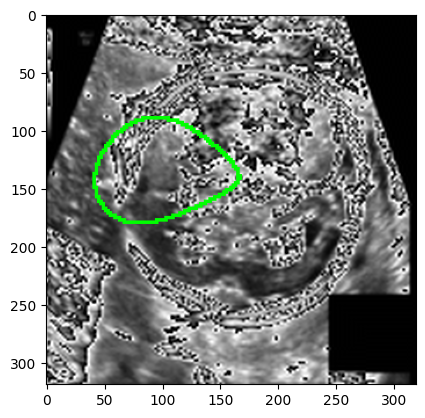

In [ ]:

#mask = ndi.binary_fill_holes(predictions1[1])
threshold = 0.9
binary_mask = predictions1[124] > threshold

# Invert binary mask
inverted_mask = 1 - binary_mask

# Apply Gaussian filter to inverted mask
sigma = 25
filtered_mask = cv2.GaussianBlur(inverted_mask.astype(np.float32), (0, 0), sigma)

# Threshold the filtered mask to get binary mask
threshold2 = 0.68
filtered_binary_mask = filtered_mask > threshold2

# Invert binary mask to get final filled mask
filled_mask = 1 - filtered_binary_mask
fil_mask = filled_mask.astype(np.uint8)

show_img_mask(test_dataset[124], fil_mask)

another example

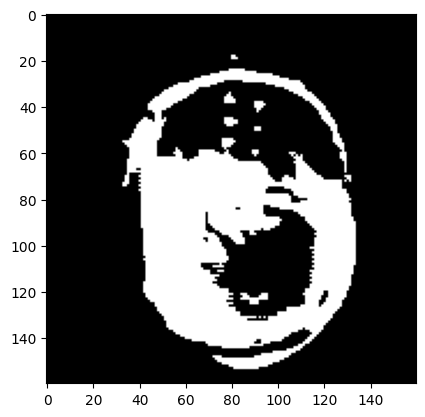

In [ ]:
mask = ndi.binary_fill_holes(predictions1[0]) 
plt.imshow(mask, cmap= 'gray')
plt.show()
#show_img_mask(test_dataset[3], mask)

In [ ]:
#h=[0,124]

original mask on image

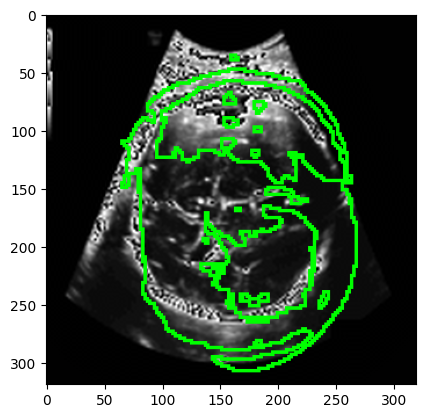

In [ ]:
show_img_mask(test_dataset[0], predictions1[0])

processed mask

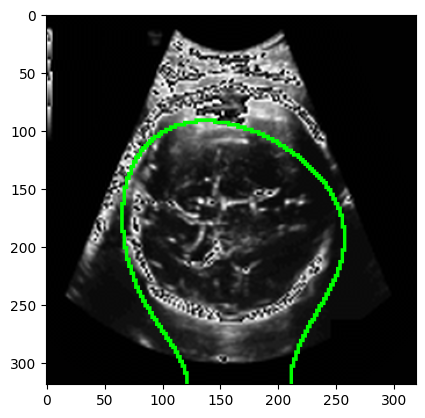

In [ ]:
v=0
#mask = ndi.binary_fill_holes(predictions1[1])
threshold = 0.9
binary_mask = predictions1[v] > threshold

# Invert binary mask
inverted_mask = 1 - binary_mask

# Apply Gaussian filter to inverted mask
sigma = 25
filtered_mask = cv2.GaussianBlur(inverted_mask.astype(np.float32), (0, 0), sigma)

# Threshold the filtered mask to get binary mask
threshold2 = 0.68
filtered_binary_mask = filtered_mask > threshold2

# Invert binary mask to get final filled mask
filled_mask = 1 - filtered_binary_mask
fil_mask = filled_mask.astype(np.uint8)

show_img_mask(test_dataset[v], fil_mask)

original mask

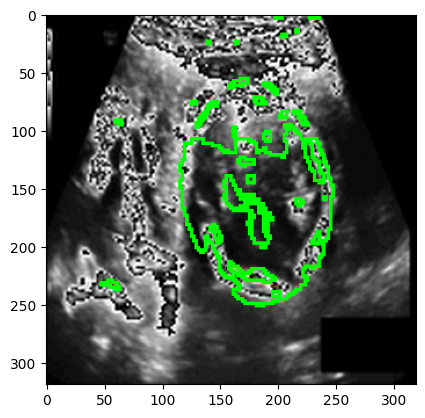

In [ ]:
show_img_mask(test_dataset[27], predictions1[27])

processed mask

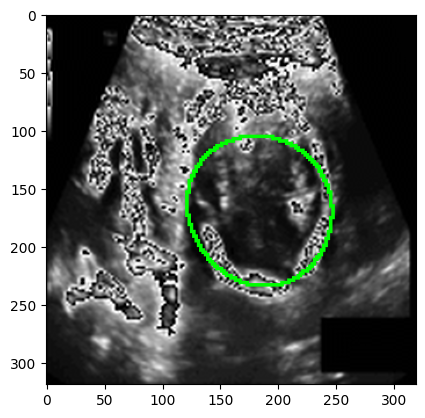

In [ ]:
v=27
#mask = ndi.binary_fill_holes(predictions1[1])
threshold = 0.9
binary_mask = predictions1[v] > threshold

# Invert binary mask
inverted_mask = 1 - binary_mask

# Apply Gaussian filter to inverted mask
sigma = 25
filtered_mask = cv2.GaussianBlur(inverted_mask.astype(np.float32), (0, 0), sigma)

# Threshold the filtered mask to get binary mask
threshold2 = 0.68
filtered_binary_mask = filtered_mask > threshold2

# Invert binary mask to get final filled mask
filled_mask = 1 - filtered_binary_mask
fil_mask = filled_mask.astype(np.uint8)

show_img_mask(test_dataset[v], fil_mask)